# Regression analysis

## Libraries and settings

In [1]:
# Libraries
import os
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Show current working directory
print(os.getcwd())

/workspaces/data_analytics/GK/Week_08


## Import data

In [2]:
# Columns
columns = ['Offer_Id', 
           'Price_num', 
           'Mileage_num', 
           'HP_num', 
           'Make', 
           'Fuel_Type', 
           'Transmission', 
           'Init_Regist_MY']

# Read the data
df_orig = pd.read_csv('autoscout24_data_prepared.csv', 
                      sep=",", 
                      encoding='utf-8',
                      usecols=columns)

# Rename variable 'web-scraper-order' to 'apmt_id'
df_orig = df_orig.rename(columns={'Mileage_num': 'Mileage',
                                  'HP_num': 'HP',
                                  'Price_num': 'Price'})

# Extract year
df_orig['Init_Regist_MY'] = df_orig['Init_Regist_MY'].astype(str)
df_orig['Year'] = df_orig['Init_Regist_MY'].str.split('.').str[1].astype(int)
df_orig.drop('Init_Regist_MY', axis=1, inplace=True)

# Remove missing values
df = df_orig.dropna()
df.head(5)

# Remove duplicates
df = df.drop_duplicates()
df.head(5)

# Remove some extreme prices; keep only fuel type 'Diesel' and 'Benzin'
df = df.loc[(df['Price'] >= 10000) & (df['Price'] <= 100000) & (df['Fuel_Type'].isin(['Diesel','Benzin']))]
df


,Offer_Id,Fuel_Type,Transmission,Make,Mileage,HP,Price,Year
0,7324420,Diesel,Automatisiertes Schaltgetriebe,AUDI,75000,245,22500,2014
1,7512768,Benzin,Automat sequentiell,MERCEDES-BENZ,46655,184,23749,2013
2,7512034,Benzin,Automat sequentiell,MERCEDES-BENZ,138955,306,18500,2011
3,7512728,Benzin,Automatisiertes Schaltgetriebe,MERCEDES-BENZ,43000,360,36000,2015
4,7490242,Benzin,Automatisiertes Schaltgetriebe,AUDI,43300,252,48500,2018
...,...,...,...,...,...,...,...,...
3964,6058456,Benzin,Automat,BENTLEY,26200,405,38500,2001
3966,7137137,Benzin,Automatisiertes Schaltgetriebe,FERRARI,78000,400,58400,2002
3967,6758841,Benzin,Automatik-Getriebe,MERCEDES-BENZ,315000,232,15900,1987
3968,7461330,Benzin,Automat sequentiell,MERCEDES-BENZ,85000,525,42000,2007


## One-hot encoding of categorical variables

In [3]:
# Perform one-hot encoding
one_hot_encoded = pd.get_dummies(df['Fuel_Type']).astype(int)

# Concatenate the new one-hot encoded columns with the original DataFrame
df = pd.concat([df, one_hot_encoded], axis=1)
df

,Offer_Id,Fuel_Type,Transmission,Make,Mileage,HP,Price,Year,Benzin,Diesel
0,7324420,Diesel,Automatisiertes Schaltgetriebe,AUDI,75000,245,22500,2014,0,1
1,7512768,Benzin,Automat sequentiell,MERCEDES-BENZ,46655,184,23749,2013,1,0
2,7512034,Benzin,Automat sequentiell,MERCEDES-BENZ,138955,306,18500,2011,1,0
3,7512728,Benzin,Automatisiertes Schaltgetriebe,MERCEDES-BENZ,43000,360,36000,2015,1,0
4,7490242,Benzin,Automatisiertes Schaltgetriebe,AUDI,43300,252,48500,2018,1,0
...,...,...,...,...,...,...,...,...,...,...
3964,6058456,Benzin,Automat,BENTLEY,26200,405,38500,2001,1,0
3966,7137137,Benzin,Automatisiertes Schaltgetriebe,FERRARI,78000,400,58400,2002,1,0
3967,6758841,Benzin,Automatik-Getriebe,MERCEDES-BENZ,315000,232,15900,1987,1,0
3968,7461330,Benzin,Automat sequentiell,MERCEDES-BENZ,85000,525,42000,2007,1,0


## Create train and test samples (train = 80%, test = 20% of the data)

In [4]:
# Create train and test samples
X_train, X_test, y_train, y_test = train_test_split(df[['Mileage', 'HP', 'Year', 'Benzin']], 
                                                    df['Price'], 
                                                    test_size=0.20, 
                                                    random_state=42)
# Show X_train
print('X_train:')
print(X_train.head(), '\n')

# Show y_train
print('y_train:')
print(y_train.head())

X_train:
      Mileage   HP  Year  Benzin
968     64000  136  2014       0
3914   205000  400     2       1
3068    52700  211   201       1
1047   270000  258  2014       0
2700    39000  105  2015       1 

y_train:
968     22900
3914    19500
3068    15900
1047    28000
2700    10900
Name: Price, dtype: int64


## Multiple linear regression

In [5]:
# Add constant to the model
X_train_const = sm.add_constant(X_train)

# Create the multiple regression model
olsmod = sm.OLS(y_train, X_train_const)
olsres = olsmod.fit()

# Print full model output
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     547.0
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:55:37   Log-Likelihood:                -24798.
No. Observations:                2276   AIC:                         4.961e+04
Df Residuals:                    2271   BIC:                         4.963e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.935e+04   1615.244     11.979      0.0

### Plot histogram of multiple linear regression residuals

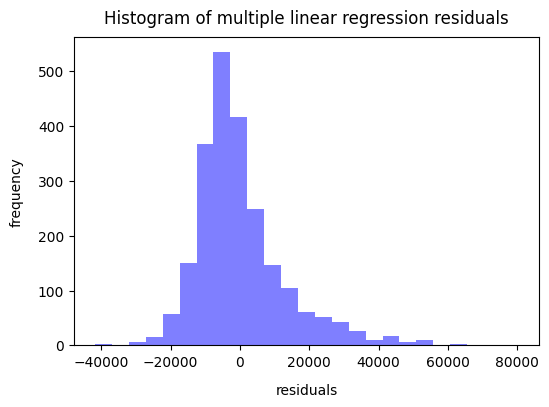

In [6]:
# Plot histogram of residuals
fig = plt.figure( figsize=(6,4))
n, bins, patches = plt.hist(x=olsres.resid, 
                            bins=25, 
                            color='blue',
                            alpha=0.5
                   )

# Set labels
plt.xlabel('residuals', fontsize=10, labelpad=10)
plt.ylabel('frequency', fontsize=10, labelpad=10)
plt.title('Histogram of multiple linear regression residuals', fontsize=12, pad=10)

plt.show()

## Random forest regression

### Fit Random forest regression model

In [7]:
X, y = make_regression(n_features=4, 
                       n_informative=2,
                       random_state=5, 
                       shuffle=False)


reg_rf = RandomForestRegressor(n_estimators=500, 
                               max_depth=10, 
                               random_state=5)
reg_rf.fit(X_train, y_train)

# Calculate coefficient of determination (R-squared)
print('R-squared:', reg_rf.score(X_test, y_test).round(4))

R-squared: 0.6538


### Plot histogram of random forest regression residuals

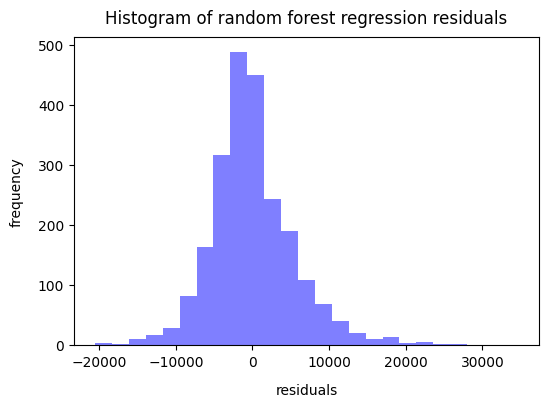

In [10]:
# Calculate residuals
y_pred = reg_rf.predict(X_train)

# Calculate residuals by subtracting actual target values from predicted values
residuals = y_train - y_pred

# Plot histogram of residuals
fig = plt.figure( figsize=(6,4))
n, bins, patches = plt.hist(x=residuals, 
                            bins=25, 
                            color='blue',
                            alpha=0.5
                   )

# Set labels
plt.xlabel('residuals', fontsize=10, labelpad=10)
plt.ylabel('frequency', fontsize=10, labelpad=10)
plt.title('Histogram of random forest regression residuals', fontsize=12, pad=10)

plt.show()

### Show feature importance

Index(['HP', 'Mileage', 'Year', 'Benzin'], dtype='object')
[0.50869432 0.27945113 0.17965969 0.03219486]


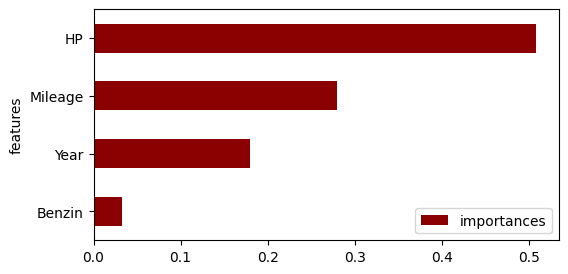

In [11]:
cols = X_train.columns

# Derive feature importance from random forest
importances = reg_rf.feature_importances_
std         = np.std([tree.feature_importances_ for tree in reg_rf.estimators_], axis=0)
indices     = np.argsort(importances)[::-1]

# Print col-names and importances-values
print( cols[indices] )
print( importances[indices] )

# Barplot with feature importance
df_fi = pd.DataFrame({'features':cols,'importances': importances})
df_fi.sort_values('importances', inplace=True)
df_fi.plot(kind='barh', 
           y='importances', 
           x='features', 
           color='darkred', 
           figsize=(6,3))

plt.show()